In [1]:
#!nvidia-smi

In [68]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [69]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 5,
    "validation_file" : 2,
    "test_file" : 2,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 1e-5,
    "epoch" : 5,
    "model_name" : "LSTM2",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/57861 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6480 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15793 [00:00<?, ?it/s]

In [122]:
torch.set_default_dtype(torch.float32)
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = nn.LSTM(1,self.hidden_size,4,batch_first=True,bias=False)
        self.layer3 = nn.Dropout(p=0.2)
        self.layer2 = nn.LayerNorm(self.hidden_size)
        self.layer4 = nn.Linear(self.hidden_size,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1,_ = self.layer1(input)
        h2 = self.layer2(h1[:,-1,:])
        h3 = self.layer3(h2)
        output = self.layer4(h3)
        output = torch.multiply(output,0.04)
        return output


In [72]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              50,339,840
├─Dropout: 1-2                           --
├─LayerNorm: 1-3                         4,096
├─Linear: 1-4                            2,048
Total params: 50,345,984
Trainable params: 50,345,984
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              50,339,840
├─Dropout: 1-2                           --
├─LayerNorm: 1-3                         4,096
├─Linear: 1-4                            2,048
Total params: 50,345,984
Trainable params: 50,345,984
Non-trainable params: 0

In [73]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],1)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [74]:
loss_fn = torch.nn.L1Loss()

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [76]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1809 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

train loss :  0.014150892466253114
val loss :  0.01798295927704266


  0%|          | 0/1809 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

train loss :  0.013857278204059426
val loss :  0.01795448919315592


  0%|          | 0/1809 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

train loss :  0.013831669294977957
val loss :  0.018027263195576643


  0%|          | 0/1809 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

train loss :  0.013827436048314965
val loss :  0.01799167794092457


  0%|          | 0/1809 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

train loss :  0.013822842378012705
val loss :  0.01798240548128834


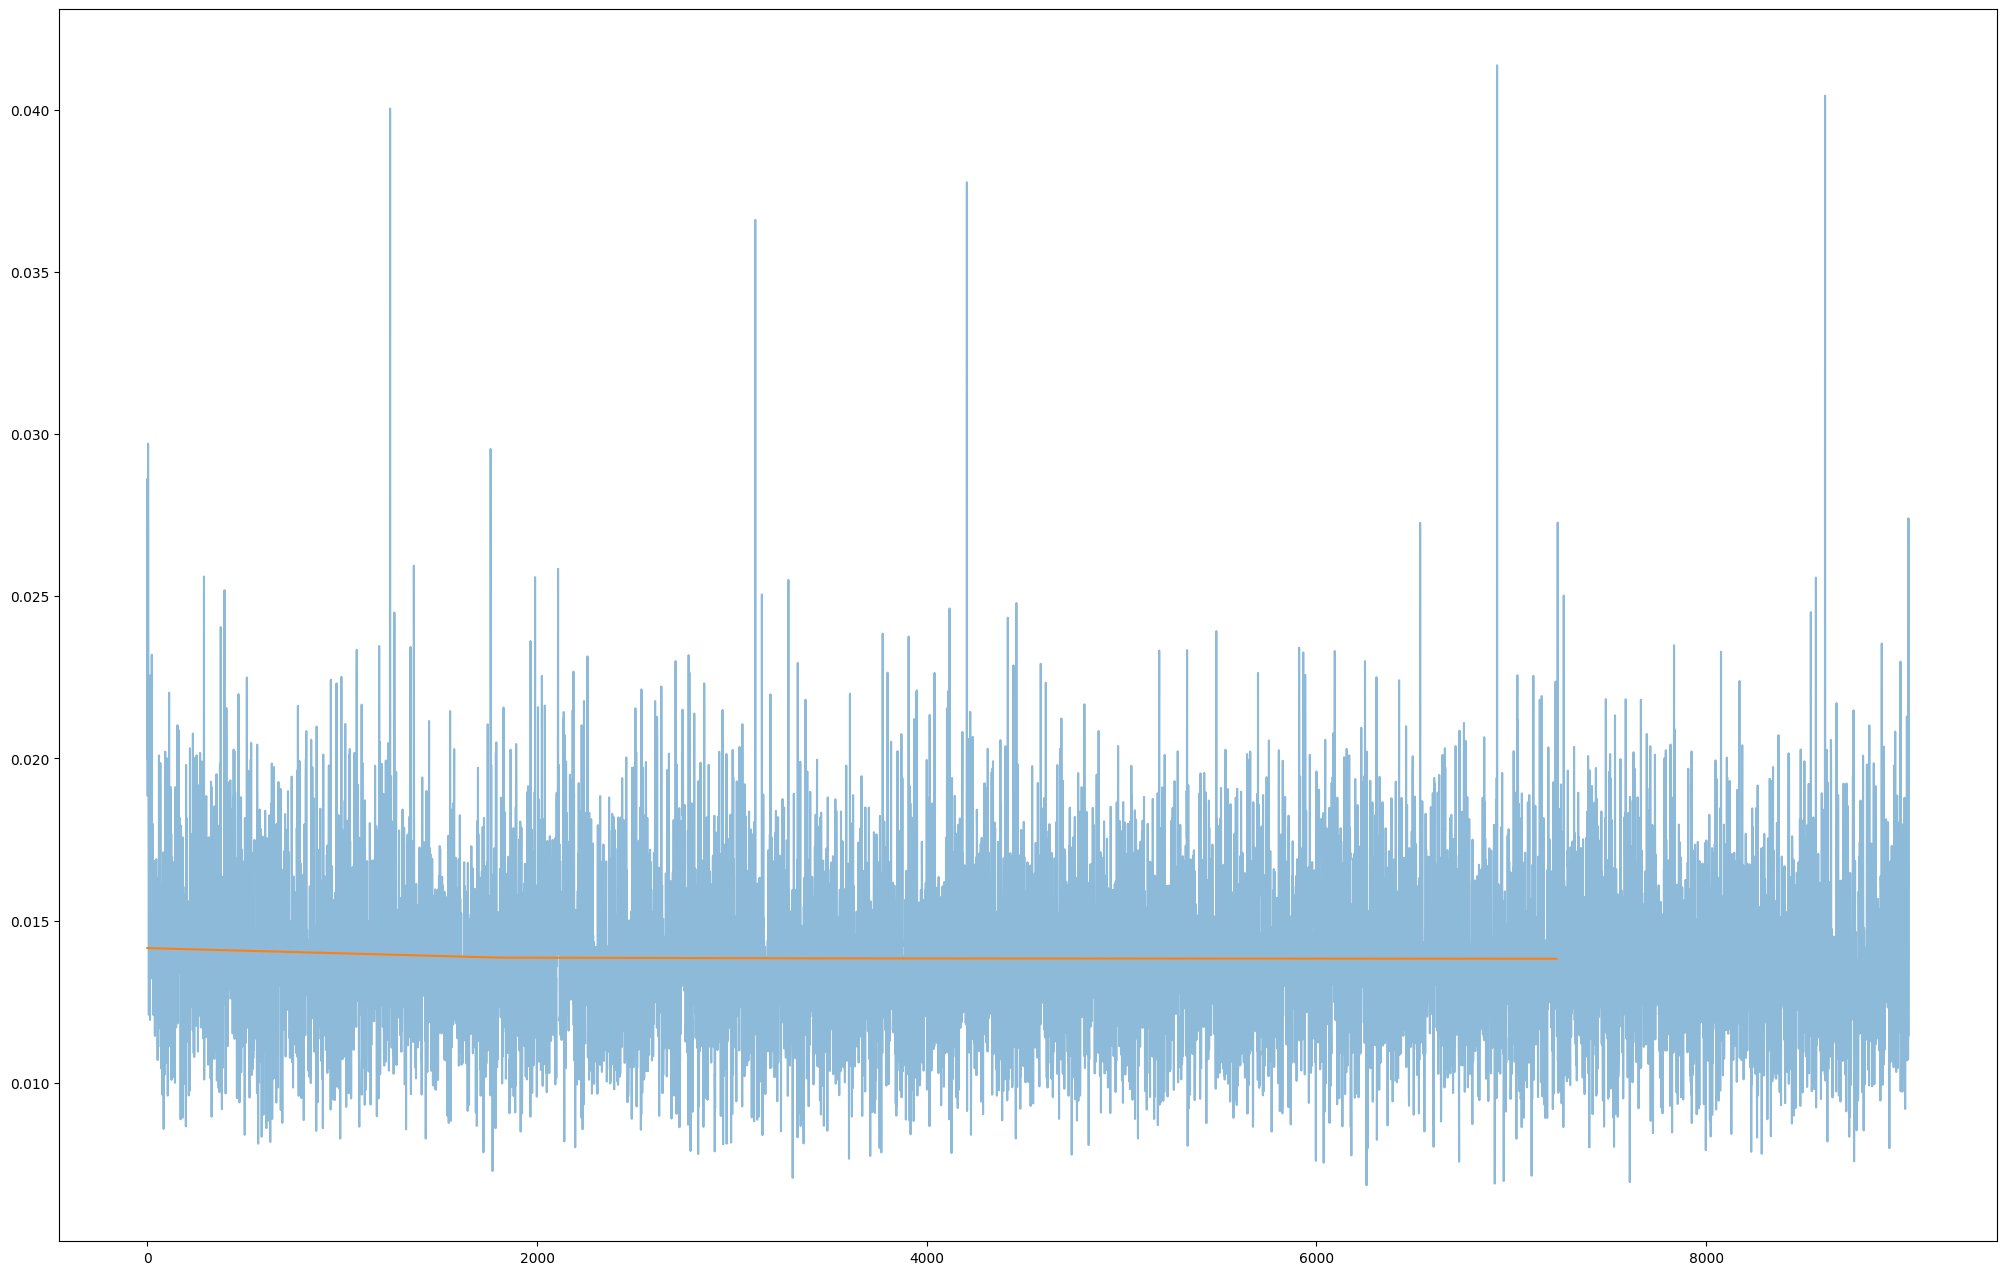

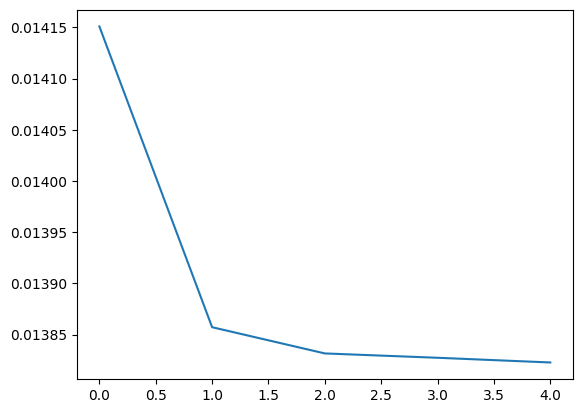

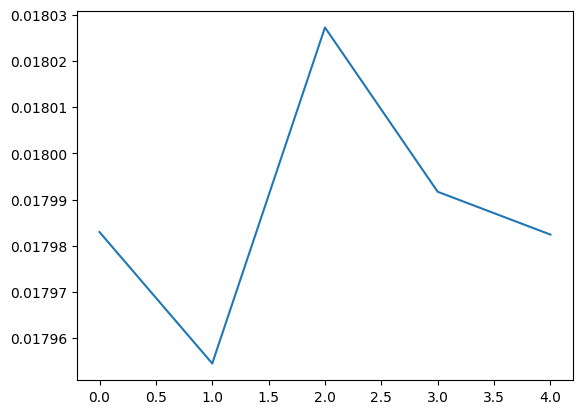

In [99]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [123]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [124]:
best_model = StockLSTM()
# best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTM(1, 512, num_layers=4, bias=False, batch_first=True)
  (layer3): Dropout(p=0.2, inplace=False)
  (layer2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layer4): Linear(in_features=512, out_features=1, bias=False)
)

In [125]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/494 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

0.00026053708
-0.0012186255
-0.0014428052
0.0034003938
-0.0033878828
0.00012792066
-0.000351108
0.0019013569
-0.0009927609
-0.0017622405
-0.00051638705
-0.0016450743
-0.00062576466
0.0003801205
0.0021906807
0.00057874236
0.0004688926
-0.0004809815
0.0002561075
0.0011459669
0.00038320018
0.0011277489
0.001314651
-0.0018334581
-0.00033988443
0.00435314
0.00019450061
-8.8511515e-05
6.8556656e-06
8.145261e-05
0.001170375
-0.00062795123
-0.00044924248
-0.000564536
-0.000728443
0.00034986783
-0.00025928448
0.00018843722
-0.0005646994
0.0013392146
0.00030216028
-0.00019069684
0.00052843516
-0.0009780864
-0.000681989
-0.0011151448
0.00069177
-0.0008413255
-0.00055455585
-0.00046656007
0.0005536147
0.00012539627
0.0011906758
5.381266e-05
-0.00041121125
0.0006439162
0.00050486985
0.00093596056
-0.00027789798
0.00010073353
0.0002310288
-0.00043999104
0.0001503166
-0.00026173028
0.0011396344
0.00020724648
-0.0003276969
0.00013022545
-0.00029214352
0.0008057594
0.0020304844
-0.00017969638
0.0001449

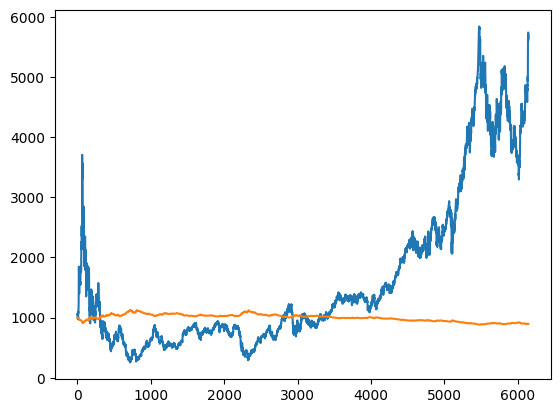

In [126]:
plot_dataset = StockDatasetLogReturn(["./data/A.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
rd.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(input[None,4,:,None])
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        output = output.to(torch.device("cpu")).numpy()
        print(output[0][0])

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real)
plt.plot(predict)
plt.show()

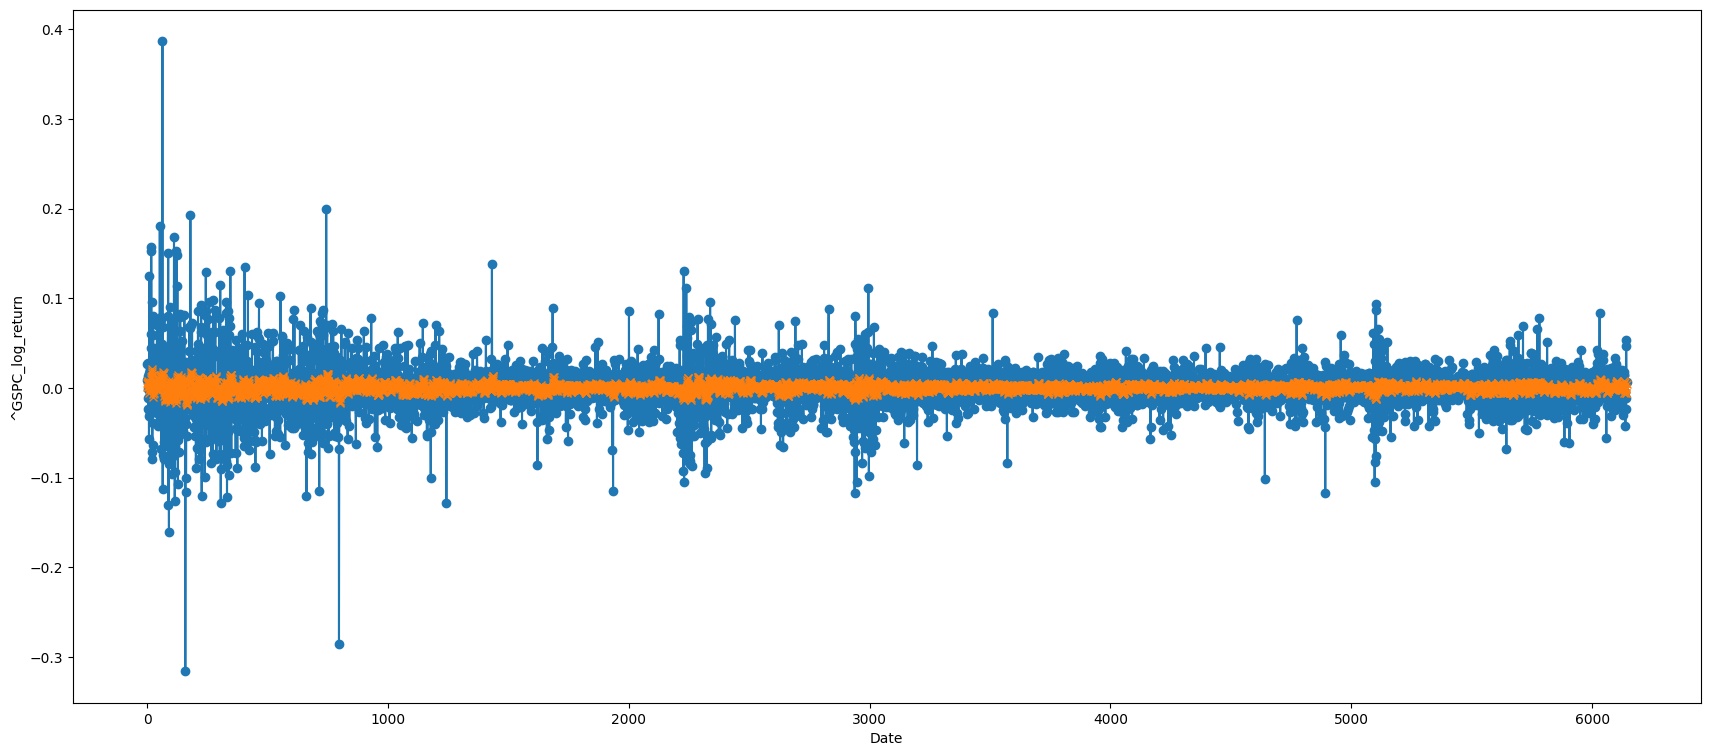

In [104]:
log_real_output = list(map(math.log,real_output))
log_predict_output = list(map(math.log,predict_output))
plt.figure(figsize=(21, 9))
plt.plot(log_real_output, label="Actual", marker='o')
plt.plot(log_predict_output, label= "Predicted",marker='x')
plt.xlabel('Date')
plt.ylabel('^GSPC_log_return')
plt.show()

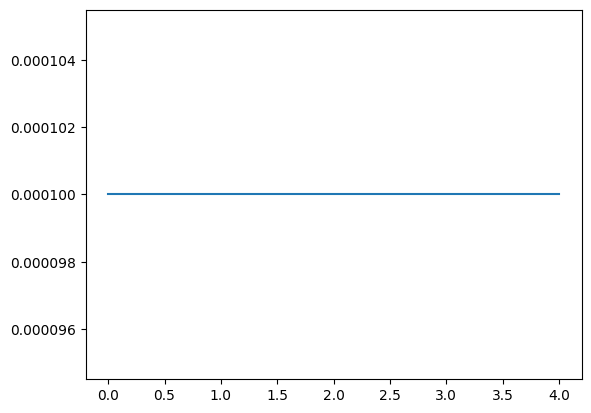

In [86]:
plt.plot(learning_rates)
plt.show()